In [1]:
from torchvision import transforms
from utils import *
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings; warnings.simplefilter('ignore')
import pickle as pk
import pandas as pd
import ast
import os
import pickle
import numpy as np

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# Load model checkpoint
# checkpoint = 'checkpoint_ssd300.pth.tar'
checkpoint = 'checkpoint_ssd300_experiment2.pth.tar'
checkpoint = torch.load(checkpoint)
start_epoch = checkpoint['epoch'] + 1
print('\nLoaded checkpoint from epoch %d.\n' % start_epoch)
model = checkpoint['model']
model = model.to(device)
model.eval()

# Transforms
resize = transforms.Resize((300, 300))
to_tensor = transforms.ToTensor()
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

cuda

Loaded checkpoint from epoch 51.



In [3]:
labels = ('nilam', 'guava', 'sawo', 'taro','bamboo', 'coffeearabica','lychee','aroid','cinnamon',
             'mango','papaya','dragonfruit','vanilla','jackfruit','frangipani','sugarpalm','whitepepper',
             'snakefruit','waterguava','cacao','zodia','starfruit','passiflora','durian','mangosteen','banana')

label_map = {k: v + 1 for v, k in enumerate(labels)}
label_map['background'] = 0
rev_label_map = {v: k for k, v in label_map.items()}  # Inverse mapping
distinct_colors = ['#e6194b', '#3cb44b', '#ffe119', '#0082c8', '#f58231', '#911eb4', '#46f0f0', '#f032e6',
                   '#d2f53c', '#fabebe', '#008080', '#000080', '#aa6e28', '#fffac8', '#800000', '#aaffc3', '#808000',
                   '#ffd8b1', '#e6beff', '#808080', '#FFFFFF', '#FFFFFF', '#FFFFFF','#FFFFFF','#FFFFFF','#FFFFFF', '#FFFFFF']
label_color_map = {k: distinct_colors[i] for i, k in enumerate(label_map.keys())}

In [4]:
def detect(original_image, min_score, max_overlap, top_k, suppress=None):
    """
    Detect objects in an image with a trained SSD300, and visualize the results.

    :param original_image: image, a PIL Image
    :param min_score: minimum threshold for a detected box to be considered a match for a certain class
    :param max_overlap: maximum overlap two boxes can have so that the one with the lower score is not suppressed via Non-Maximum Suppression (NMS)
    :param top_k: if there are a lot of resulting detection across all classes, keep only the top 'k'
    :param suppress: classes that you know for sure cannot be in the image or you do not want in the image, a list
    :return: annotated image, a PIL Image
    """

    # Transform
    image = normalize(to_tensor(resize(original_image)))

    # Move to default device
    image = image.to(device)

    # Forward prop.
    predicted_locs, predicted_scores = model(image.unsqueeze(0))

    # Detect objects in SSD output
    det_boxes, det_labels, det_scores = model.detect_objects(predicted_locs, predicted_scores, min_score=min_score,
                                                             max_overlap=max_overlap, top_k=top_k)

    # Move detections to the CPU
    det_boxes = det_boxes[0].to('cpu')

    # Transform to original image dimensions
    original_dims = torch.FloatTensor(
        [original_image.width, original_image.height, original_image.width, original_image.height]).unsqueeze(0)
    det_boxes = det_boxes * original_dims

    # Decode class integer labels
    det_labels = [rev_label_map[l] for l in det_labels[0].to('cpu').tolist()]

    # If no objects found, the detected labels will be set to ['0.'], i.e. ['background'] in SSD300.detect_objects() in model.py
#     if det_labels == ['background']:
#         # Just return original image
#         return original_image

    return det_labels

In [5]:
path = "../../data/bali-26/"
folders = os.listdir(path)

In [6]:
result = {}
for class_name in folders:
    class_path = os.path.join(path,class_name)
    images = os.listdir(class_path)
    
    num_files = 0
    top1 = 0
    topN = 0
    for image in images:
        if '.pk' in image:
            continue
        image_path = os.path.join(class_path, image)
        original_image = Image.open(image_path, mode='r').convert('RGB')
        predicted_labels = detect(original_image, min_score=0.2, max_overlap=0.5, top_k=3)
        num_files += 1
        
        if class_name == predicted_labels[0]:
            top1 += 1
        if class_name in predicted_labels:
            topN += 1
    
    top1_score = float(top1 / num_files)
    topN_score = float(topN / num_files)
    top1_error = 100*float("%.3f" %(1.0 - top1_score))
    topN_error = 100*float("%.3f" %(1.0 - topN_score))
    result[class_name] = {
        'top1_error': top1_error,
        'topN_error': topN_error
    }
    
    print (result[class_name])

KeyboardInterrupt: 

In [15]:
result

{'nilam': {'top1_error': 0.0, 'topN_error': 0.0},
 'guava': {'top1_error': 1.4000000000000001, 'topN_error': 1.4000000000000001},
 'sawo': {'top1_error': 0.2, 'topN_error': 0.2},
 'taro': {'top1_error': 7.3999999999999995, 'topN_error': 1.5},
 'bamboo': {'top1_error': 9.1, 'topN_error': 9.1},
 'coffeearabica': {'top1_error': 0.4, 'topN_error': 0.4},
 'lychee': {'top1_error': 17.2, 'topN_error': 13.5},
 'aroid': {'top1_error': 4.3999999999999995, 'topN_error': 3.1},
 'cinnamon': {'top1_error': 5.4, 'topN_error': 4.0},
 'mango': {'top1_error': 6.9, 'topN_error': 0.0},
 'papaya': {'top1_error': 18.3, 'topN_error': 13.5},
 'dragonfruit': {'top1_error': 1.7000000000000002, 'topN_error': 0.4},
 'vanilla': {'top1_error': 1.4000000000000001,
  'topN_error': 1.4000000000000001},
 'jackfruit': {'top1_error': 4.1000000000000005, 'topN_error': 1.2},
 'frangipani': {'top1_error': 0.6, 'topN_error': 0.0},
 'sugarpalm': {'top1_error': 68.0, 'topN_error': 46.800000000000004},
 'whitepepper': {'top1_er

In [40]:
df = pd.DataFrame(result).transpose()

df.columns = ['top1_error', 'top3_error']

fig = df.plot(kind='bar', figsize=(12,12), xlabel = 'classes', ylabel ='%error', stacked = False, grid =True).get_figure()

In [16]:
import json

In [18]:
# with open("./erros.json", 'r') as f:
#     t = json.load(f)

### Experiment 2 - without cacao, sugerpalm and banana

In [7]:
path = "../../data/bali-26/"
folders = os.listdir(path)

In [9]:
result = {}
predictions = []
for class_name in folders:
    if class_name in ['banana', 'sugarpalm', 'cacao']: # The classes not included in experiment2
        continue
    class_path = os.path.join(path,class_name)
    images = os.listdir(class_path)
    
    num_files = 0
    top1 = 0
    topN = 0
    for image in images:
        if '.pk' in image:
            continue
        image_path = os.path.join(class_path, image)
        original_image = Image.open(image_path, mode='r').convert('RGB')
        predicted_labels = detect(original_image, min_score=0.2, max_overlap=0.5, top_k=3)
        predictions.append((predicted_labels,class_name))
        num_files += 1
        
        if class_name == predicted_labels[0]:
            top1 += 1
        if class_name in predicted_labels:
            topN += 1
    
    top1_score = float(top1 / num_files)
    topN_score = float(topN / num_files)
    top1_error = 100*float("%.3f" %(1.0 - top1_score))
    topN_error = 100*float("%.3f" %(1.0 - topN_score))
    result[class_name] = {
        'top1_error': top1_error,
        'topN_error': topN_error
    }
    
    print (result[class_name])

{'top1_error': 0.0, 'topN_error': 0.0}
{'top1_error': 1.6, 'topN_error': 1.6}
{'top1_error': 0.4, 'topN_error': 0.4}
{'top1_error': 0.7000000000000001, 'topN_error': 0.1}
{'top1_error': 24.2, 'topN_error': 18.9}
{'top1_error': 0.0, 'topN_error': 0.0}
{'top1_error': 27.400000000000002, 'topN_error': 26.5}
{'top1_error': 2.9000000000000004, 'topN_error': 2.6}
{'top1_error': 2.9000000000000004, 'topN_error': 2.4}
{'top1_error': 11.1, 'topN_error': 2.1}
{'top1_error': 21.3, 'topN_error': 16.0}
{'top1_error': 0.8999999999999999, 'topN_error': 0.0}
{'top1_error': 1.9, 'topN_error': 1.6}
{'top1_error': 2.8000000000000003, 'topN_error': 2.1999999999999997}
{'top1_error': 23.3, 'topN_error': 8.7}
{'top1_error': 0.4, 'topN_error': 0.1}
{'top1_error': 7.199999999999999, 'topN_error': 2.9000000000000004}
{'top1_error': 24.8, 'topN_error': 18.6}
{'top1_error': 0.5, 'topN_error': 0.1}
{'top1_error': 6.4, 'topN_error': 3.9}
{'top1_error': 0.7000000000000001, 'topN_error': 0.1}
{'top1_error': 21.3, 't

In [10]:
result

{'nilam': {'top1_error': 0.0, 'topN_error': 0.0},
 'guava': {'top1_error': 1.6, 'topN_error': 1.6},
 'sawo': {'top1_error': 0.4, 'topN_error': 0.4},
 'taro': {'top1_error': 0.7000000000000001, 'topN_error': 0.1},
 'bamboo': {'top1_error': 24.2, 'topN_error': 18.9},
 'coffeearabica': {'top1_error': 0.0, 'topN_error': 0.0},
 'lychee': {'top1_error': 27.400000000000002, 'topN_error': 26.5},
 'aroid': {'top1_error': 2.9000000000000004, 'topN_error': 2.6},
 'cinnamon': {'top1_error': 2.9000000000000004, 'topN_error': 2.4},
 'mango': {'top1_error': 11.1, 'topN_error': 2.1},
 'papaya': {'top1_error': 21.3, 'topN_error': 16.0},
 'dragonfruit': {'top1_error': 0.8999999999999999, 'topN_error': 0.0},
 'vanilla': {'top1_error': 1.9, 'topN_error': 1.6},
 'jackfruit': {'top1_error': 2.8000000000000003,
  'topN_error': 2.1999999999999997},
 'frangipani': {'top1_error': 23.3, 'topN_error': 8.7},
 'whitepepper': {'top1_error': 0.4, 'topN_error': 0.1},
 'snakefruit': {'top1_error': 7.199999999999999,
  

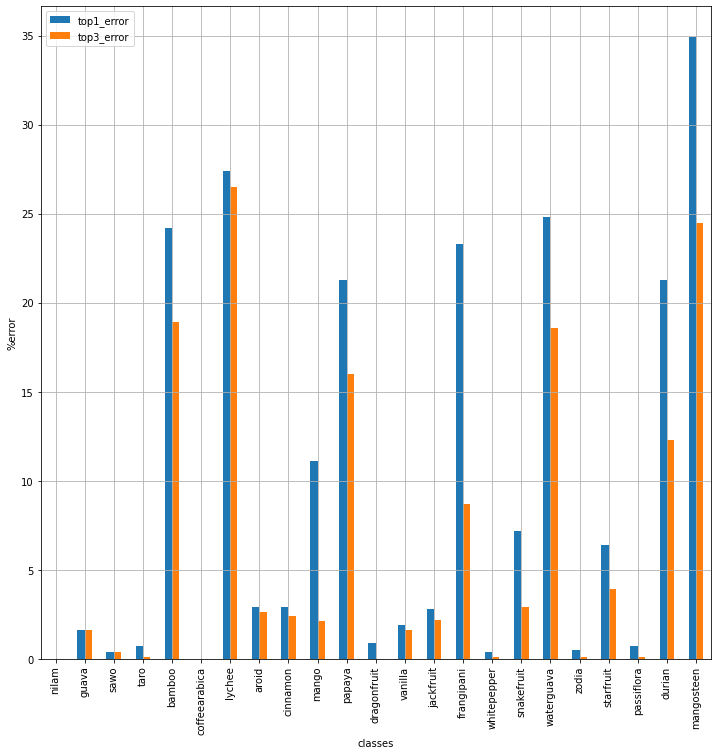

In [11]:
df = pd.DataFrame(result).transpose()

df.columns = ['top1_error', 'top3_error']

fig = df.plot(kind='bar', figsize=(12,12), xlabel = 'classes', ylabel ='%error', stacked = False, grid =True).get_figure()